In [1]:
from fastkaggle import *

## Getting Set Up  
We can use `fastkaggle` to set up the dataset which makes things a lot easier for us.

In [2]:
comp = "paddy-disease-classification"

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [3]:
path

Path('paddy-disease-classification')

In [4]:
from fastai.vision.all import *
set_seed(42)

path.ls()

(#4) [Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/train_images'),Path('paddy-disease-classification/train.csv')]

## Take a look at the training images  
We see the sizes are variable, so we will resize them all with our data preprocessing.

In [5]:
trn_path = path/"train_images"
files = get_image_files(trn_path)

(480, 640)


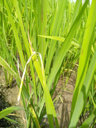

In [6]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [7]:
from fastcore.parallel import *
def f(o): return PILImage.create(o).size
# sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

NameError: name 'sizes' is not defined

In [8]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method="squish"),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

All the images should nwo be *squished* down to the same size. Then, random crops of the image of size 128 will be used for training the batches.

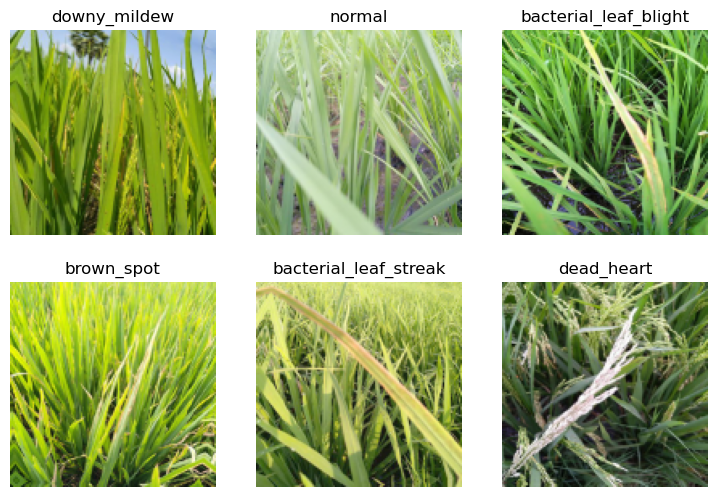

In [9]:
dls.show_batch(max_n=6)

## Creating a first model
We choose the `resnet26d` model to try our first pass.

In [10]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path=".").to_fp16()

model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

SuggestedLRs(valley=0.002511886414140463, slide=0.0020892962347716093)

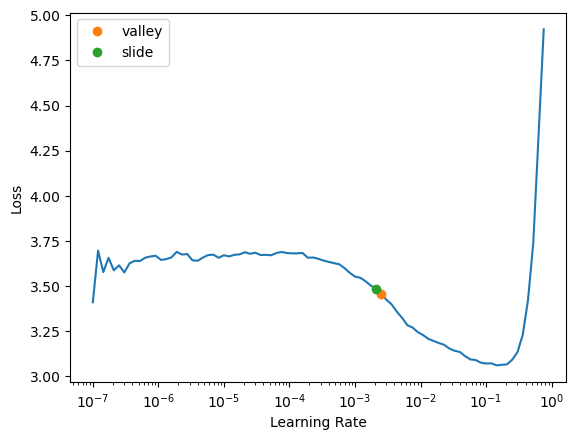

In [11]:
learn.lr_find(suggest_funcs=(valley, slide))

In [12]:
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.739339,1.248261,0.384911,00:49


epoch,train_loss,valid_loss,error_rate,time
0,1.130246,0.778256,0.242191,00:50
1,0.766477,0.490404,0.156655,00:50
2,0.554194,0.397964,0.123498,00:50


Pretty good!

## Submitting to Kaggle

In [13]:
ss = pd.read_csv(path/"sample_submission.csv")
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


All those NaNs have to be a label with the disease name. So, we get our predictions then map them to a label:

In [15]:
tst_files = get_image_files(path/"test_images").sorted()
tst_dl = dls.test_dl(tst_files)

In [16]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

tensor([7, 8, 6,  ..., 8, 1, 5])

In [17]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [18]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                downy_mildew
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [19]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,downy_mildew
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [20]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'initial rn26d 128px', comp)

100%|████████████████████████████████████████████████████████████████| 70.1k/70.1k [00:00<00:00, 79.8kB/s]
